In [1]:
# Import the fucking useful libraries =)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import scipy.stats as sp
import scipy.spatial.distance as spsd
from operator import itemgetter
import random
from IPython import display
from helpers import *
import pickle
from joblib import Parallel, delayed

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [2]:
# Define here the data set
dataset = '../data/data_train.csv'

In [3]:
data = prepare_data(dataset)

Load the dataset


In [4]:
data.head()


,Id,Prediction,UserID,MovieID
0,r44_c1,4,43,0
1,r61_c1,3,60,0
2,r67_c1,4,66,0
3,r72_c1,3,71,0
4,r86_c1,5,85,0


In [35]:
U, I, R, U_i = variables(data)

Prepare the variables


# Nearest Neighbors

In [11]:
folder = "./pickles/"


In [10]:
%%time
nearest_neighbors(folder, R, I, U_i, method="msd")

Start Calculating Nearest Neighbors for method msd
  100/1000 done!
  200/1000 done!
  300/1000 done!
  400/1000 done!
  500/1000 done!
  600/1000 done!
  700/1000 done!
  800/1000 done!
  900/1000 done!
  1000/1000 done!
CPU times: user 4min 47s, sys: 228 ms, total: 4min 47s
Wall time: 4min 47s


In [40]:
%%time
nearest_neighbors(folder, R, I, U_i, method="pearson")

Start Calculating Nearest Neighbors for method pearson
  100/1000 done!
  200/1000 done!
  300/1000 done!
  400/1000 done!
  500/1000 done!
  600/1000 done!
  700/1000 done!
  800/1000 done!
  900/1000 done!
  1000/1000 done!
CPU times: user 5min 28s, sys: 288 ms, total: 5min 28s
Wall time: 5min 28s


In [12]:
%%time
nearest_neighbors(folder, R, I, U_i, method="cosine")

Start Calculating Nearest Neighbors for method cosine
  100/1000 done!
  200/1000 done!
  300/1000 done!
  400/1000 done!
  500/1000 done!
  600/1000 done!
  700/1000 done!
  800/1000 done!
  900/1000 done!
  1000/1000 done!
CPU times: user 4min 43s, sys: 132 ms, total: 4min 43s
Wall time: 4min 43s


# Training

In [8]:
# Before having the train and testing set, we need to unload the memory a bit
del U
del I
del R
del U_i

In [10]:
def training_validation(data, p_value=0.1):
    validation_array = []
    train_array = []
    for i in range(len(data)):
        if random.random() < p_value:
            validation_array.append(data.iloc[i])
        else:
            train_array.append(data.iloc[i])
            
    variables = list(train_array[0].keys())
    
    train = pd.DataFrame([[getattr(i,j) for j in variables] for i in train_array], columns = variables)
    validation = pd.DataFrame([[getattr(i,j) for j in variables] for i in validation_array], columns = variables)

    return train, validation  

In [11]:
train, validation = training_validation(data, p_value=0.01)



In [13]:
# Create training matrices
U_train, I_train, R_train, U_i_train = variables(train)

Prepare the variables


In [14]:
KK = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]

In [15]:
def rmse(a,b):
    return np.sqrt(np.mean((np.array(a)-np.array(b))**2))

def mean(i, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        return np.mean(R_G)
    
def weighted_mean(i, sim, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        return np.dot(sim, R_G)/np.sum(sim)
    
def deviation_from_mean(i, neigh, sim, R, R_G):
    if len(R_G) == 0:
        ratings = R[:,i]
        return np.mean(ratings[ratings!=np.inf])
    else:
        ratings = R[:,i]
        rating_i_mean = np.mean(ratings[ratings!=np.inf])
        r=R[:,neigh]
        r[r==np.inf] = np.nan
        mean_ = np.nanmean(r, axis=0)
        deviation = np.dot(sim, R_G-mean_)
        
        return rating_i_mean + deviation/np.sum(sim)

In [16]:
folder = "./pickles/"
model = "msd"
NN = []
similarity = []
for itm in range(1000):
    filename = folder + "NN_" + str(itm) + "_" + model + ".pickle"
    NN.append(pickle.load(open(filename, "rb")))
    filename = folder + "sim_" + str(itm) + "_" + model + ".pickle"
    similarity.append(pickle.load(open(filename, "rb")))

In [17]:
validation = validation.sort("MovieID")
validation.head()

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Id,Prediction,UserID,MovieID
0,r114_c1,3,113,0
1,r9264_c1,4,9263,0
2,r302_c2,4,301,1
3,r1636_c2,4,1635,1
4,r1117_c3,4,1116,2


KeyboardInterrupt: 

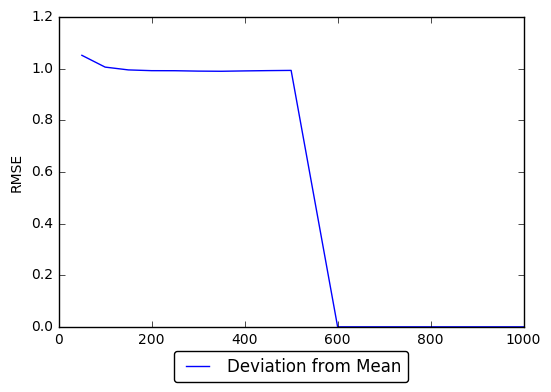

In [18]:
# Test for MSD
RMSE = np.zeros(len(KK))

for idx, k in enumerate(KK):
    n = len(validation)
    ratings = np.zeros(n)
    pred = np.zeros(n)
    prev_movie = 99999
    for i in range(n):
        pred[i] = validation.iloc[i].loc["Prediction"]
        usr = validation.iloc[i].loc["UserID"]
        movie = validation.iloc[i].loc["MovieID"]
        
        neigh = np.array(NN[movie][:k])
        sim = np.array(similarity[movie][:k])
        
        # Prepare Ratings of G
        R_G = R_train[usr, neigh]
        G = R_G!=np.inf
        R_G = R_G[G]
        neigh = neigh[G]
        sim = sim[G]
        # Put ratings
        ratings[i] = deviation_from_mean(movie, neigh, sim, R_train, R_G)
        #if (i+1)%1000 == 0:
        #    print("%i/%i done!"%(i+1, n))
    RMSE[idx] = rmse(ratings, pred)
    plt.gca().cla() 
    plt.plot(KK, RMSE, label='Deviation from Mean')
    plt.xlabel("k")
    plt.ylabel("RMSE")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [19]:
RMSE

array([ 1.05103163,  1.00539574,  0.99455411,  0.99161419,  0.99141528,
        0.98988773,  0.98929063,  0.99068676,  0.9917977 ,  0.99265679,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [20]:
best_k = KK[np.argmin(RMSE[RMSE != 0.0])]
best_k

350

In [4]:
best_k = 500

# Testing

In [5]:
# Test data
dataset_test = '../data/sampleSubmission.csv'
data_test = prepare_data(dataset_test)

# Training data
data = prepare_data(dataset)
# Prepare the data
U, I, R, U_i = variables(data)

Load the dataset
Load the dataset
Prepare the variables


In [6]:
data_test.head()

,Id,Prediction,UserID,MovieID
0,r37_c1,3,36,0
1,r73_c1,3,72,0
2,r156_c1,3,155,0
3,r160_c1,3,159,0
4,r248_c1,3,247,0


In [7]:
def pred(data):
    usr = data.loc["UserID"]
    movie = data.loc["MovieID"]  
    
    neigh = np.array(NN[movie][:best_k])
    sim = np.array(similarity[movie][:best_k])
    
    # Prepare Ratings of G
    R_G = R_train[usr, neigh]
    G = R_G!=np.inf
    R_G = R_G[G]
    neigh = neigh[G]
    sim = sim[G]
    
    val = deviation_from_mean(movie, neigh, sim, R_train, R_G)
    
    return val

In [8]:
nbr_jobs = 8

In [9]:
%%time
predictions = Parallel(n_jobs=nbr_jobs)(delayed(pred)(data_test.iloc[i]) for i in range(len(data_test)))

JoblibNameError: JoblibNameError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/gael/anaconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/gael/anaconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f1c0d0f4030, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/gael/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f1c0d0f4030, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/gael/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    648 
    649         If a global instance already exists, this reinitializes and starts it
    650         """
    651         app = cls.instance(**kwargs)
    652         app.initialize(argv)
--> 653         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    654 
    655 #-----------------------------------------------------------------------------
    656 # utility functions, for convenience
    657 #-----------------------------------------------------------------------------

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-06T14:40:51.713420', 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'session': 'FB8C7CC8229E47D88DFF6E6F2735D77A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'FB8C7CC8229E47D88DFF6E6F2735D77A']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-06T14:40:51.713420', 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'session': 'FB8C7CC8229E47D88DFF6E6F2735D77A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'FB8C7CC8229E47D88DFF6E6F2735D77A'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-06T14:40:51.713420', 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'session': 'FB8C7CC8229E47D88DFF6E6F2735D77A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3E347402CC274276B9771D93B283666D', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\npredictions = Parallel(n_jobs=nbr_jobs)(d...ata_test.iloc[i]) for i in range(len(data_test)))', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-9-a28eff6d94e1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f1bb03c7320, executi..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f1c0519aa50, file "<ipython-input-9-a28eff6d94e1>", line 1>
        result = <ExecutionResult object at 7f1bb03c7320, executi..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f1c0519aa50, file "<ipython-input-9-a28eff6d94e1>", line 1>, result=<ExecutionResult object at 7f1bb03c7320, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f1c0519aa50, file "<ipython-input-9-a28eff6d94e1>", line 1>
        self.user_global_ns = {'I': array([  0,   1,   2,   3,   4,   5,   6,   7,  ...90, 991, 992, 993, 994, 995, 996, 997, 998, 999]), 'In': ['', '# Import the fucking useful libraries =)\nimport ...more columns\npd.options.display.max_columns = 100', "# Define here the data set\ndataset = '../data/data_train.csv'", 'data = prepare_data(dataset)', 'best_k = 500', "# Test data\ndataset_test = '../data/sampleSubmis...# Prepare the data\nU, I, R, U_i = variables(data)", 'data_test.head()', 'def pred(data):\n    usr = data.loc["UserID"]\n   ...ie, neigh, sim, R_train, R_G)\n    \n    return val', 'nbr_jobs = 8', "get_ipython().run_cell_magic('time', '', 'predic...a_test.iloc[i]) for i in range(len(data_test)))')"], 'Out': {6:         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'R': array([[ inf,  inf,  inf, ...,  inf,  inf,  inf]...      [ inf,  inf,  inf, ...,  inf,  inf,   3.]]), 'U': array([   0,    1,    2, ..., 9997, 9998, 9999]), 'U_i': [array([  43,   60,   66,   71,   85,   89,  107,... 9815, 9816, 9846, 9872, 9909, 9931, 9963, 9991]), array([   4,   13,   24,   40,   43,   61,   78,...9853, 9874, 9931, 9935,
       9938, 9967, 9970]), array([  12,   15,   44,   46,   56,   61,   69,... 9963, 9964, 9969, 9972, 9975, 9977, 9978, 9992]), array([   1,    2,    9, ..., 9992, 9994, 9998]), array([  13,   21,   40, ..., 9975, 9977, 9984]), array([   1,    4,    5, ..., 9989, 9993, 9995]), array([  14,   15,   19, ..., 9967, 9968, 9980]), array([   1,    4,    9, ..., 9997, 9998, 9999]), array([  21,   36,   37,   61,   82,   89,  119,...9960, 9963, 9968,
       9969, 9978, 9987, 9991]), array([   0,    8,   10, ..., 9983, 9986, 9999]), array([  24,   27,   33, ..., 9968, 9975, 9981]), array([  14,   27,   84,   89,   96,   99,  120,...9876, 9908, 9911, 9913,
       9919, 9921, 9946]), array([  21,   26,   43,   69,   84,  119,  130,... 9826, 9829, 9856, 9859, 9862, 9911, 9986, 9992]), array([   3,    4,    5, ..., 9995, 9998, 9999]), array([   4,    8,   21, ..., 9981, 9987, 9993]), array([   7,   12,   14,   20,   24,   43,   56,...9947, 9950, 9958, 9969,
       9971, 9976, 9984]), array([  14,   44,   47, ..., 9995, 9998, 9999]), array([   9,   10,   20,   36,   37,   43,   52,...9938, 9960, 9980, 9987, 9994, 9995,
       9997]), array([   8,   14,   16,   68,   69,   80,   89,...9876, 9915, 9925,
       9943, 9981, 9989, 9992]), array([   9,   21,   27, ..., 9964, 9970, 9977]), ...], '_':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '_6':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '__': '', ...}
        self.user_ns = {'I': array([  0,   1,   2,   3,   4,   5,   6,   7,  ...90, 991, 992, 993, 994, 995, 996, 997, 998, 999]), 'In': ['', '# Import the fucking useful libraries =)\nimport ...more columns\npd.options.display.max_columns = 100', "# Define here the data set\ndataset = '../data/data_train.csv'", 'data = prepare_data(dataset)', 'best_k = 500', "# Test data\ndataset_test = '../data/sampleSubmis...# Prepare the data\nU, I, R, U_i = variables(data)", 'data_test.head()', 'def pred(data):\n    usr = data.loc["UserID"]\n   ...ie, neigh, sim, R_train, R_G)\n    \n    return val', 'nbr_jobs = 8', "get_ipython().run_cell_magic('time', '', 'predic...a_test.iloc[i]) for i in range(len(data_test)))')"], 'Out': {6:         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'R': array([[ inf,  inf,  inf, ...,  inf,  inf,  inf]...      [ inf,  inf,  inf, ...,  inf,  inf,   3.]]), 'U': array([   0,    1,    2, ..., 9997, 9998, 9999]), 'U_i': [array([  43,   60,   66,   71,   85,   89,  107,... 9815, 9816, 9846, 9872, 9909, 9931, 9963, 9991]), array([   4,   13,   24,   40,   43,   61,   78,...9853, 9874, 9931, 9935,
       9938, 9967, 9970]), array([  12,   15,   44,   46,   56,   61,   69,... 9963, 9964, 9969, 9972, 9975, 9977, 9978, 9992]), array([   1,    2,    9, ..., 9992, 9994, 9998]), array([  13,   21,   40, ..., 9975, 9977, 9984]), array([   1,    4,    5, ..., 9989, 9993, 9995]), array([  14,   15,   19, ..., 9967, 9968, 9980]), array([   1,    4,    9, ..., 9997, 9998, 9999]), array([  21,   36,   37,   61,   82,   89,  119,...9960, 9963, 9968,
       9969, 9978, 9987, 9991]), array([   0,    8,   10, ..., 9983, 9986, 9999]), array([  24,   27,   33, ..., 9968, 9975, 9981]), array([  14,   27,   84,   89,   96,   99,  120,...9876, 9908, 9911, 9913,
       9919, 9921, 9946]), array([  21,   26,   43,   69,   84,  119,  130,... 9826, 9829, 9856, 9859, 9862, 9911, 9986, 9992]), array([   3,    4,    5, ..., 9995, 9998, 9999]), array([   4,    8,   21, ..., 9981, 9987, 9993]), array([   7,   12,   14,   20,   24,   43,   56,...9947, 9950, 9958, 9969,
       9971, 9976, 9984]), array([  14,   44,   47, ..., 9995, 9998, 9999]), array([   9,   10,   20,   36,   37,   43,   52,...9938, 9960, 9980, 9987, 9994, 9995,
       9997]), array([   8,   14,   16,   68,   69,   80,   89,...9876, 9915, 9925,
       9943, 9981, 9989, 9992]), array([   9,   21,   27, ..., 9964, 9970, 9977]), ...], '_':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '_6':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '__': '', ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/knn/<ipython-input-9-a28eff6d94e1> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 get_ipython().run_cell_magic('time', '', 'predictions = Parallel(n_jobs=nbr_jobs)(delayed(pred)(data_test.iloc[i]) for i in range(len(data_test)))')
      7 
      8 
      9 
     10 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell='predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))')
   2110             # This will need to be updated if the internal calling logic gets
   2111             # refactored, or else we'll be expanding the wrong variables.
   2112             stack_depth = 2
   2113             magic_arg_s = self.var_expand(line, stack_depth)
   2114             with self.builtin_trap:
-> 2115                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = 'predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))'
   2116             return result
   2117 
   2118     def find_line_magic(self, magic_name):
   2119         """Find and return a line magic by name.

...........................................................................
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/knn/<decorator-gen-59> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))', local_ns=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', 'predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))', None), **k={})
    183     validate_type(magic_kind)
    184 
    185     # This is a closure to capture the magic_kind.  We could also use a class,
    186     # but it's overkill for just that one bit of state.
    187     def magic_deco(arg):
--> 188         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', 'predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))', None)
        k = {}
    189 
    190         if callable(arg):
    191             # "Naked" decorator call (just @foo, no args)
    192             func = arg

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='predictions = Parallel(n_jobs=nbr_jobs)(delayed(...ata_test.iloc[i]) for i in range(len(data_test)))', local_ns=None)
   1175             st = clock2()
   1176             out = eval(code, glob, local_ns)
   1177             end = clock2()
   1178         else:
   1179             st = clock2()
-> 1180             exec(code, glob, local_ns)
        code = <code object <module> at 0x7f1bbe69a0c0, file "<timed exec>", line 1>
        glob = {'I': array([  0,   1,   2,   3,   4,   5,   6,   7,  ...90, 991, 992, 993, 994, 995, 996, 997, 998, 999]), 'In': ['', '# Import the fucking useful libraries =)\nimport ...more columns\npd.options.display.max_columns = 100', "# Define here the data set\ndataset = '../data/data_train.csv'", 'data = prepare_data(dataset)', 'best_k = 500', "# Test data\ndataset_test = '../data/sampleSubmis...# Prepare the data\nU, I, R, U_i = variables(data)", 'data_test.head()', 'def pred(data):\n    usr = data.loc["UserID"]\n   ...ie, neigh, sim, R_train, R_G)\n    \n    return val', 'nbr_jobs = 8', "get_ipython().run_cell_magic('time', '', 'predic...a_test.iloc[i]) for i in range(len(data_test)))')"], 'Out': {6:         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'R': array([[ inf,  inf,  inf, ...,  inf,  inf,  inf]...      [ inf,  inf,  inf, ...,  inf,  inf,   3.]]), 'U': array([   0,    1,    2, ..., 9997, 9998, 9999]), 'U_i': [array([  43,   60,   66,   71,   85,   89,  107,... 9815, 9816, 9846, 9872, 9909, 9931, 9963, 9991]), array([   4,   13,   24,   40,   43,   61,   78,...9853, 9874, 9931, 9935,
       9938, 9967, 9970]), array([  12,   15,   44,   46,   56,   61,   69,... 9963, 9964, 9969, 9972, 9975, 9977, 9978, 9992]), array([   1,    2,    9, ..., 9992, 9994, 9998]), array([  13,   21,   40, ..., 9975, 9977, 9984]), array([   1,    4,    5, ..., 9989, 9993, 9995]), array([  14,   15,   19, ..., 9967, 9968, 9980]), array([   1,    4,    9, ..., 9997, 9998, 9999]), array([  21,   36,   37,   61,   82,   89,  119,...9960, 9963, 9968,
       9969, 9978, 9987, 9991]), array([   0,    8,   10, ..., 9983, 9986, 9999]), array([  24,   27,   33, ..., 9968, 9975, 9981]), array([  14,   27,   84,   89,   96,   99,  120,...9876, 9908, 9911, 9913,
       9919, 9921, 9946]), array([  21,   26,   43,   69,   84,  119,  130,... 9826, 9829, 9856, 9859, 9862, 9911, 9986, 9992]), array([   3,    4,    5, ..., 9995, 9998, 9999]), array([   4,    8,   21, ..., 9981, 9987, 9993]), array([   7,   12,   14,   20,   24,   43,   56,...9947, 9950, 9958, 9969,
       9971, 9976, 9984]), array([  14,   44,   47, ..., 9995, 9998, 9999]), array([   9,   10,   20,   36,   37,   43,   52,...9938, 9960, 9980, 9987, 9994, 9995,
       9997]), array([   8,   14,   16,   68,   69,   80,   89,...9876, 9915, 9925,
       9943, 9981, 9989, 9992]), array([   9,   21,   27, ..., 9964, 9970, 9977]), ...], '_':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '_6':         Id  Prediction  UserID  MovieID
0   r37_...        0
4  r248_c1           3     247        0, '__': '', ...}
        local_ns = None
   1181             end = clock2()
   1182             out = None
   1183         wall_end = wtime()
   1184         # Compute actual times and report

...........................................................................
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/knn/<timed exec> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=8), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=8)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
NameError                                          Tue Dec  6 14:40:51 2016
PID: 3130                     Python 3.5.2: /home/gael/anaconda3/bin/python
...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function pred>, (Id            r37_c1
Prediction         3
UserID...   36
MovieID            0
Name: 0, dtype: object,), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/gael/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function pred>
        args = (Id            r37_c1
Prediction         3
UserID...   36
MovieID            0
Name: 0, dtype: object,)
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/knn/<ipython-input-7-5c3dd0f110ab> in pred(data=Id            r37_c1
Prediction         3
UserID...   36
MovieID            0
Name: 0, dtype: object)
      1 
      2 def pred(data):
      3     usr = data.loc["UserID"]
      4     movie = data.loc["MovieID"]  
----> 5     
      6     neigh = np.array(NN[movie][:best_k])
      7     sim = np.array(similarity[movie][:best_k])
      8     
      9     # Prepare Ratings of G
     10     R_G = R_train[usr, neigh]
     11     G = R_G!=np.inf

NameError: name 'NN' is not defined
___________________________________________________________________________

In [176]:
np.min(predictions)

-0.17822781735444071

In [178]:
for i in range(len(predictions)):
    if predictions[i] > 5:
        predictions[i] = 5
    elif predictions[i] < 1:
        predictions[i] = 1

In [179]:
data_test['Prediction'] = predictions
data_test = data_test.sort(["MovieID", "UserID"])
data_test.head()

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Id,Prediction,UserID,MovieID
0,r37_c1,3.384988,36,0
1,r73_c1,2.997531,72,0
2,r156_c1,3.847079,155,0
3,r160_c1,3.345039,159,0
4,r248_c1,3.255987,247,0


In [180]:
data_test = data_test.drop(['UserID', 'MovieID'], axis=1)

In [181]:
data_test.to_csv('pred_knn_item-based.csv', index=False)

In [182]:
data_test.head()

,Id,Prediction
0,r37_c1,3.384988
1,r73_c1,2.997531
2,r156_c1,3.847079
3,r160_c1,3.345039
4,r248_c1,3.255987
